**Task Sheet 2 - CANN for Neo-Hookean Material (corrected version based on given feedback)**

**Importing required libraries such as numpy and torch for data generation and matplotlib for data visualization.**

In [14]:
import matplotlib
matplotlib.rcParams["text.usetex"] = True
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

**Defining desired settings for torch model.**

In [35]:
# Setting the default dtype precision and the number of threads used.
torch.set_default_dtype(torch.float32)
torch.set_num_threads(4)

# Choose a device for later major calculations as CPU.
device = torch.device("cpu")
print(f"Using {device} device")
device = torch.device(device)

model_file = "CANN.torch" # File path for saving the trained NN later

Using cpu device


**Initializing the hyperparameters and the class for the Constitutive Artificial Neural Network (CANN).**

In [36]:
epochs = 200 # Number of training iterations
lr = 0.01 # Learning rate for the training algorithm
criterion = nn.MSELoss() # Evaluate the results using the Mean Square Error criterion

In [37]:
class CANN(nn.Module):
    def __init__(self):
        super(CANN, self).__init__()
        
        # Store the weights w_{i,j} with i=1,2 and j=1,..,8 as  neural network parameters.
        self.w1 = nn.Parameter(torch.randn(8))
        self.w2 = nn.Parameter(torch.randn(8))

    # Define the forward function with respect to the CANN architecture as described in/on (N).
    def forward(self, I12):
        I1     = I12[:, 0]
        I2     = I12[:, 1]
        
        # Compute the output, in this case the Helmholtz Free Energy Density, with respect to the equation (N).
        psi    = self.w2[0]*self.w1[0]*(I1-3) + self.w2[1]*(torch.exp(self.w1[1]*(I1-3))-1) 
        + self.w2[2]*self.w1[2]*(I1-3)**2 + self.w2[3]*(torch.exp(self.w1[3]*(I1-3)**2)-1) 
        + self.w2[4]*self.w1[4]*(I2-3) + self.w2[5]*(torch.exp(self.w1[5]*(I2-3))-1) 
        + self.w2[6]*self.w1[6]*(I2-3)**2 + self.w2[7]*(torch.exp(self.w1[7]*(I2-3)**2)-1)
        
        return psi

**Defining the function to compute the Helmholtz Free Energy Density.**

In [38]:
def helmholtz_free_energy_F(F, miu=384.614, lambd=576.923, plot_psi=True):
    """
    Computes the Helmholtz free energy for a compressible Neo-Hookean material in 2D.

    Inputs:
        F     (torch.Tensor): Deformation gradient tensor of shape (N, 2, 2)
        miu   (float)       : Shear modulus (default 384.614 Pa)
        lambd (float)       : First Lamé parameter (default 576.923 Pa)
    
    Returns:
        Psi   (torch.Tensor): Helmholtz free energy for each point.
        J     (torch.Tensor): Jacobi determinant
        I1    (torch.Tensor): First invariant of C
    """
    # Compute the Right Cauchy-Green deformation tensor: C = Fᵀ * F
    C = torch.matmul(F.transpose(1, 2), F)
    
    # Compute invariants
    J = torch.det(F)  # Jacobian determinant
    J = torch.clamp(J, min=1e-6)  # Prevent numerical issues
    I1 = torch.einsum('bii->b', C)  # I1 = tr(C)
    
    # Compute Helmholtz free energy Ψ = (λ/2) * (lnJ)^2 - μ * lnJ + (μ/2) * (I1 - 2)
    psi = (lambd / 2) * (torch.log(J))**2 - miu * torch.log(J) + (miu / 2) * (I1 - 2)

    # Normalize for better generalization
    J = (J - J.mean()) / J.std()
    I1 = (I1 - I1.mean()) / I1.std()
    psi = (psi - psi.mean()) / psi.std()

    # Plot Helmholtz free energy distribution
    if plot_psi:
        plt.figure(figsize=(8, 6))
        plt.hist(psi.detach().numpy(), bins=50, color='b', alpha=0.7, label=r'Helmholtz Free Energy $\Psi$')
        plt.xlabel(r'$\Psi$')
        plt.ylabel('Frequency')
        plt.title('Helmholtz Free Energy Distribution')
        plt.legend()
        plt.show()

    return psi, J, I1

**Generating the datasets for training and test.**

In [39]:
def generate_F_samples(N, sample_min=0.5, sample_max=1.5):
    """
    Generates N random deformation gradient tensors F.

    Inputs:
        N (int): Number of samples
        sample_min (float): Minimum scaling factor
        sample_max (float): Maximum scaling factor

    Returns:
        F (torch.Tensor): Deformation gradient tensor of shape (N, 2, 2)
    """
    # Generate random deformation gradients
    F = torch.eye(2).unsqueeze(0).repeat(N, 1, 1).to(device)  # Identity matrix as base
    F += (sample_max - sample_min) * (torch.rand(N, 2, 2).to(device) - 0.5)  # Add small perturbations
    return F


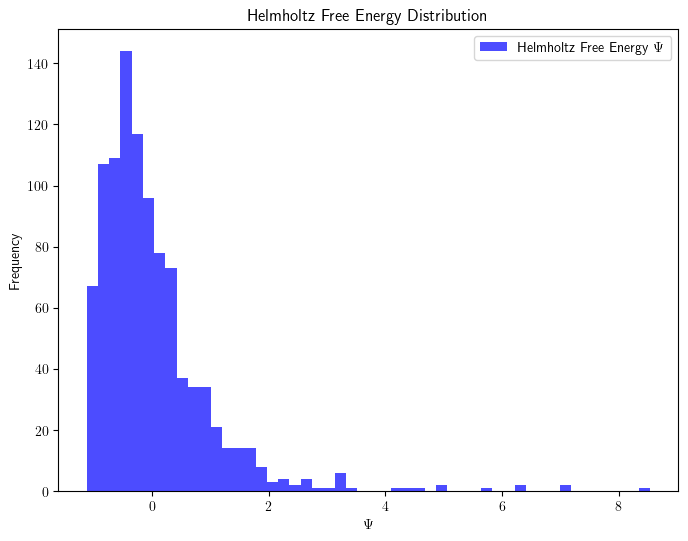

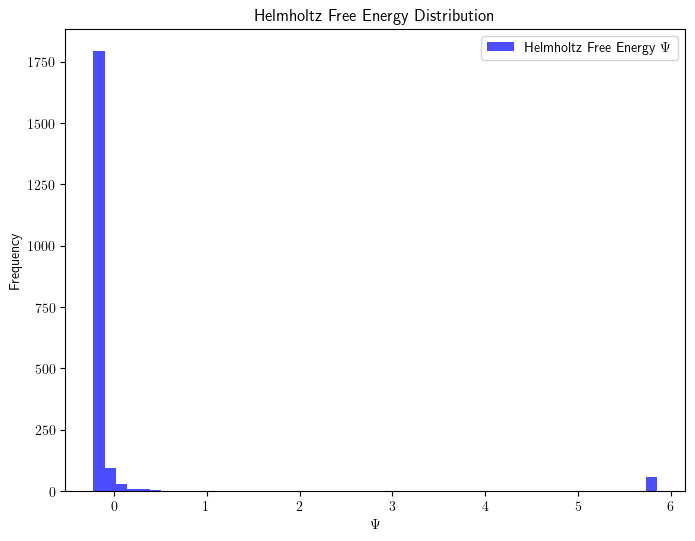

In [40]:
# Define hyperparameters
samples = 1000  # Number of training samples
test_samples = 2000  # Number of test samples
batch_size = 16  # Batch size for DataLoader
sample_min, sample_max = 0.5, 1.5  # Range for F values

# Generate training data
F_train = generate_F_samples(samples)
psi_train, J_train, I1_train = helmholtz_free_energy_F(F_train)

# Stack I1 and J as input features
I1J_train = torch.stack((I1_train, J_train), dim=1).to(device)

# Generate test data (outside training range)
F_test = generate_F_samples(test_samples, sample_min=0.2, sample_max=1.8)
psi_test, J_test, I1_test = helmholtz_free_energy_F(F_test)
I1J_test = torch.stack((I1_test, J_test), dim=1).to(device)

# Create DataLoader for training
train_data = TensorDataset(I1J_train, psi_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=False)

# Create DataLoader for testing
test_data = TensorDataset(I1J_test, psi_test)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=False)

**Defining functions to perform a test run with the designed Neural Network model, compare the outputs with the target values, calculate the loss value and plot the evaluation.**

In [41]:
def evaluate(model, I1J_test, psi_test):
    """
    Evaluates the trained model on test data.
    
    Inputs:
        model (torch.nn.Module): Trained neural network
        I1J_test (torch.Tensor): Input test features [I1, J]
        psi_test (torch.Tensor): Ground truth Psi values
    
    Returns:
        outputs (list): Model predictions
        targets (list): True Psi values
        testlosses (list): Loss values
    """
    with torch.no_grad():  # Disable autograd for evaluation
        model.eval()  # Set to evaluation mode
        outputs = []
        targets = []
        testlosses = []

        out = model(I1J_test.to(device))  # Run inference
        
        # Convert to numpy for plotting
        outputs.append(out.cpu().detach().numpy())
        targets.append(psi_test.cpu().detach().numpy())
        testlosses.append(criterion(out, psi_test.to(device)).item())

    return outputs, targets, testlosses

In [42]:
def eval_and_plot(model):
    """
    Evaluates the model and plots the results.
    """
    outputs_test, targets_test, testlosses = evaluate(model, I1J_test, psi_test)

    # 3D plot of Psi predictions
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(I1J_test[:, 0].cpu().numpy(), I1J_test[:, 1].cpu().numpy(), targets_test, color='b', label='Target')
    ax.scatter(I1J_test[:, 0].cpu().numpy(), I1J_test[:, 1].cpu().numpy(), outputs_test[0], color='g', label='Predicted')

    ax.set_xlabel(r'$I_1$')
    ax.set_ylabel(r'$J$')
    ax.set_zlabel(r'$\Psi$')
    plt.legend()
    plt.title('Helmholtz Free Energy Prediction')
    plt.show()


**Defining the function for training.**

In [43]:
def train(train_loader, learn_rate, EPOCHS):
    """
    Trains the neural network model.
    
    Inputs:
        train_loader (DataLoader): Training data loader
        learn_rate (float): Learning rate for optimization
        EPOCHS (int): Number of training epochs
    
    Returns:
        model (torch.nn.Module): Trained model
    """
    model = CANN().to(device)  # Initialize model
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=1e-5)

    print("Starting Training...")
    avg_losses = torch.zeros(EPOCHS)

    for epoch in range(EPOCHS):
        model.train()  # Set to training mode
        avg_loss = 0.
        counter = 0

        for x, label in train_loader:
            counter += 1
            model.zero_grad()
            
            out = model(x.to(device))  # Forward pass
            loss = criterion(out, label.to(device))  # Compute loss
            
            loss.backward()  # Compute gradients
            optimizer.step()  # Update parameters

            avg_loss += loss.item()

            if counter % 20 == 0:
                print(f"Epoch {epoch} | Step {counter}/{len(train_loader)} | Avg Loss: {avg_loss / counter:.6f}")

        print(f"Epoch {epoch}/{EPOCHS} | Total Loss: {avg_loss / len(train_loader):.6f}")
        avg_losses[epoch] = avg_loss / len(train_loader)

        if epoch % 10 == 0:  # Plot every 10 epochs
            eval_and_plot(model)

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(avg_losses, "o-", label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    torch.save(model.state_dict(), model_file)  # Save model

    return model

Starting Training...
Epoch 0 | Step 20/63 | Avg Loss: 31.039456
Epoch 0 | Step 40/63 | Avg Loss: 18.370340
Epoch 0 | Step 60/63 | Avg Loss: 13.071026
Epoch 0/200 | Total Loss: 12.549853


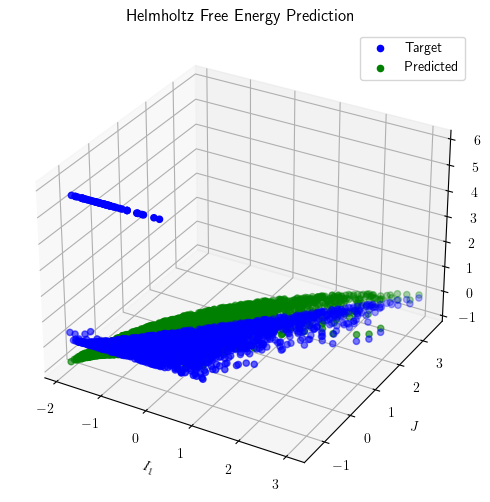

Epoch 1 | Step 20/63 | Avg Loss: 1.245604
Epoch 1 | Step 40/63 | Avg Loss: 1.431208
Epoch 1 | Step 60/63 | Avg Loss: 1.500058
Epoch 1/200 | Total Loss: 1.475792
Epoch 2 | Step 20/63 | Avg Loss: 1.628442
Epoch 2 | Step 40/63 | Avg Loss: 1.341486
Epoch 2 | Step 60/63 | Avg Loss: 1.357454
Epoch 2/200 | Total Loss: 1.441269
Epoch 3 | Step 20/63 | Avg Loss: 1.096329
Epoch 3 | Step 40/63 | Avg Loss: 1.328349
Epoch 3 | Step 60/63 | Avg Loss: 1.360556
Epoch 3/200 | Total Loss: 1.330960
Epoch 4 | Step 20/63 | Avg Loss: 1.260708
Epoch 4 | Step 40/63 | Avg Loss: 1.217089
Epoch 4 | Step 60/63 | Avg Loss: 1.317848
Epoch 4/200 | Total Loss: 1.278715
Epoch 5 | Step 20/63 | Avg Loss: 1.485629
Epoch 5 | Step 40/63 | Avg Loss: 1.343505
Epoch 5 | Step 60/63 | Avg Loss: 1.261748
Epoch 5/200 | Total Loss: 1.232637
Epoch 6 | Step 20/63 | Avg Loss: 0.980742
Epoch 6 | Step 40/63 | Avg Loss: 1.103227
Epoch 6 | Step 60/63 | Avg Loss: 1.190092
Epoch 6/200 | Total Loss: 1.203934
Epoch 7 | Step 20/63 | Avg Loss: 0

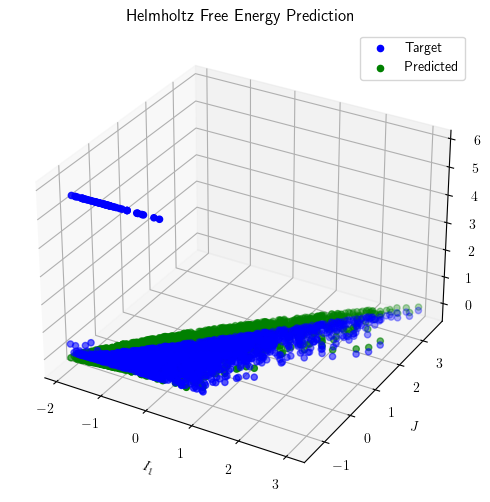

Epoch 11 | Step 20/63 | Avg Loss: 1.071826
Epoch 11 | Step 40/63 | Avg Loss: 1.046897
Epoch 11 | Step 60/63 | Avg Loss: 1.112150
Epoch 11/200 | Total Loss: 1.092793
Epoch 12 | Step 20/63 | Avg Loss: 0.954541
Epoch 12 | Step 40/63 | Avg Loss: 1.166736
Epoch 12 | Step 60/63 | Avg Loss: 1.106815
Epoch 12/200 | Total Loss: 1.075000
Epoch 13 | Step 20/63 | Avg Loss: 1.360625
Epoch 13 | Step 40/63 | Avg Loss: 1.240996
Epoch 13 | Step 60/63 | Avg Loss: 1.083174
Epoch 13/200 | Total Loss: 1.065203
Epoch 14 | Step 20/63 | Avg Loss: 1.323008
Epoch 14 | Step 40/63 | Avg Loss: 1.118851
Epoch 14 | Step 60/63 | Avg Loss: 1.045961
Epoch 14/200 | Total Loss: 1.059224
Epoch 15 | Step 20/63 | Avg Loss: 1.149053
Epoch 15 | Step 40/63 | Avg Loss: 1.057008
Epoch 15 | Step 60/63 | Avg Loss: 1.021815
Epoch 15/200 | Total Loss: 1.102984
Epoch 16 | Step 20/63 | Avg Loss: 1.274527
Epoch 16 | Step 40/63 | Avg Loss: 1.198036
Epoch 16 | Step 60/63 | Avg Loss: 1.057573
Epoch 16/200 | Total Loss: 1.044153
Epoch 17 |

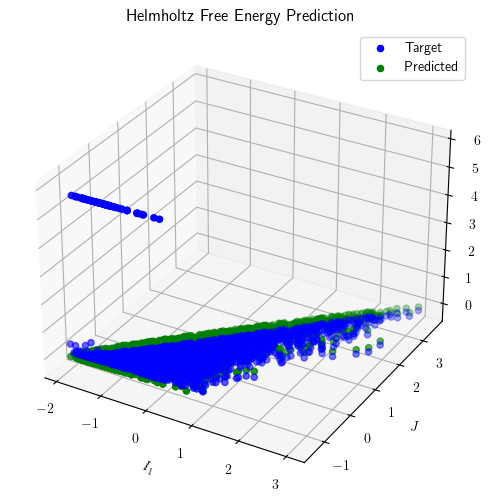

Epoch 21 | Step 20/63 | Avg Loss: 0.846116
Epoch 21 | Step 40/63 | Avg Loss: 0.959715
Epoch 21 | Step 60/63 | Avg Loss: 1.036179
Epoch 21/200 | Total Loss: 1.018905
Epoch 22 | Step 20/63 | Avg Loss: 1.279966
Epoch 22 | Step 40/63 | Avg Loss: 1.145379
Epoch 22 | Step 60/63 | Avg Loss: 1.010068
Epoch 22/200 | Total Loss: 1.021768
Epoch 23 | Step 20/63 | Avg Loss: 0.764553
Epoch 23 | Step 40/63 | Avg Loss: 1.127174
Epoch 23 | Step 60/63 | Avg Loss: 1.036163
Epoch 23/200 | Total Loss: 1.021101
Epoch 24 | Step 20/63 | Avg Loss: 0.960092
Epoch 24 | Step 40/63 | Avg Loss: 1.001368
Epoch 24 | Step 60/63 | Avg Loss: 1.032990
Epoch 24/200 | Total Loss: 1.010096
Epoch 25 | Step 20/63 | Avg Loss: 1.227256
Epoch 25 | Step 40/63 | Avg Loss: 1.166253
Epoch 25 | Step 60/63 | Avg Loss: 1.040714
Epoch 25/200 | Total Loss: 1.009915
Epoch 26 | Step 20/63 | Avg Loss: 0.961355
Epoch 26 | Step 40/63 | Avg Loss: 0.848075
Epoch 26 | Step 60/63 | Avg Loss: 0.960041
Epoch 26/200 | Total Loss: 1.059944
Epoch 27 |

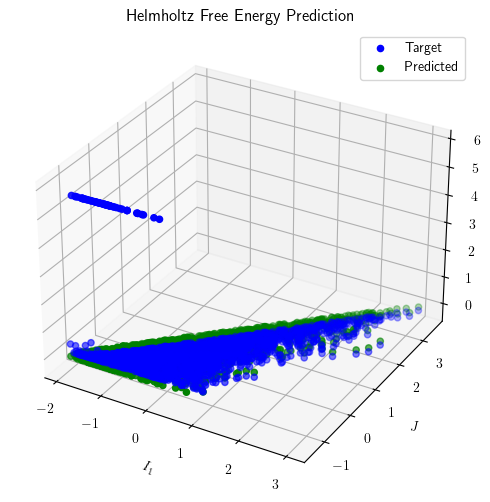

Epoch 31 | Step 20/63 | Avg Loss: 1.190503
Epoch 31 | Step 40/63 | Avg Loss: 0.944110
Epoch 31 | Step 60/63 | Avg Loss: 1.003948
Epoch 31/200 | Total Loss: 1.002843
Epoch 32 | Step 20/63 | Avg Loss: 1.206983
Epoch 32 | Step 40/63 | Avg Loss: 1.116930
Epoch 32 | Step 60/63 | Avg Loss: 1.021960
Epoch 32/200 | Total Loss: 0.999953
Epoch 33 | Step 20/63 | Avg Loss: 0.746607
Epoch 33 | Step 40/63 | Avg Loss: 0.947446
Epoch 33 | Step 60/63 | Avg Loss: 1.007222
Epoch 33/200 | Total Loss: 1.004090
Epoch 34 | Step 20/63 | Avg Loss: 1.132094
Epoch 34 | Step 40/63 | Avg Loss: 1.059188
Epoch 34 | Step 60/63 | Avg Loss: 1.016497
Epoch 34/200 | Total Loss: 1.005066
Epoch 35 | Step 20/63 | Avg Loss: 1.615638
Epoch 35 | Step 40/63 | Avg Loss: 1.139206
Epoch 35 | Step 60/63 | Avg Loss: 1.028596
Epoch 35/200 | Total Loss: 1.004990
Epoch 36 | Step 20/63 | Avg Loss: 1.294249
Epoch 36 | Step 40/63 | Avg Loss: 0.927415
Epoch 36 | Step 60/63 | Avg Loss: 1.030241
Epoch 36/200 | Total Loss: 1.001007
Epoch 37 |

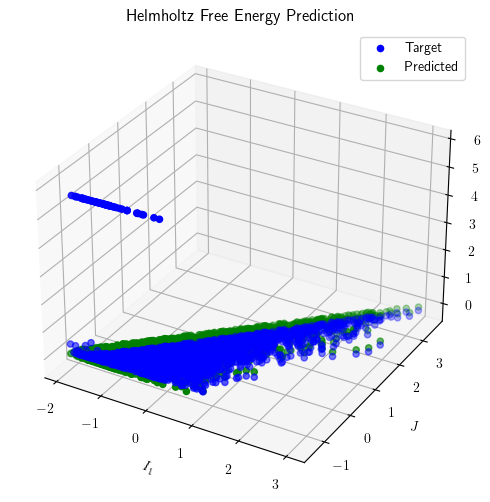

Epoch 41 | Step 20/63 | Avg Loss: 0.859313
Epoch 41 | Step 40/63 | Avg Loss: 0.906181
Epoch 41 | Step 60/63 | Avg Loss: 1.021977
Epoch 41/200 | Total Loss: 0.997782
Epoch 42 | Step 20/63 | Avg Loss: 0.777754
Epoch 42 | Step 40/63 | Avg Loss: 0.841008
Epoch 42 | Step 60/63 | Avg Loss: 0.965633
Epoch 42/200 | Total Loss: 0.995415
Epoch 43 | Step 20/63 | Avg Loss: 0.885882
Epoch 43 | Step 40/63 | Avg Loss: 0.869064
Epoch 43 | Step 60/63 | Avg Loss: 0.956724
Epoch 43/200 | Total Loss: 0.995027
Epoch 44 | Step 20/63 | Avg Loss: 1.007127
Epoch 44 | Step 40/63 | Avg Loss: 1.158433
Epoch 44 | Step 60/63 | Avg Loss: 1.010126
Epoch 44/200 | Total Loss: 0.994234
Epoch 45 | Step 20/63 | Avg Loss: 0.920486
Epoch 45 | Step 40/63 | Avg Loss: 0.980585
Epoch 45 | Step 60/63 | Avg Loss: 1.018364
Epoch 45/200 | Total Loss: 0.995050
Epoch 46 | Step 20/63 | Avg Loss: 0.620958
Epoch 46 | Step 40/63 | Avg Loss: 0.888445
Epoch 46 | Step 60/63 | Avg Loss: 1.000719
Epoch 46/200 | Total Loss: 0.999874
Epoch 47 |

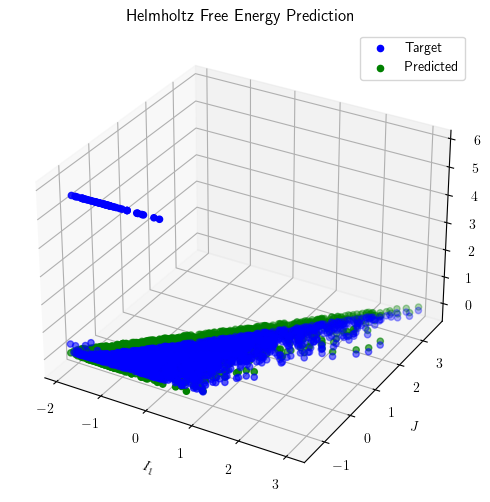

Epoch 51 | Step 20/63 | Avg Loss: 0.883127
Epoch 51 | Step 40/63 | Avg Loss: 0.891140
Epoch 51 | Step 60/63 | Avg Loss: 0.970239
Epoch 51/200 | Total Loss: 0.994310
Epoch 52 | Step 20/63 | Avg Loss: 0.777489
Epoch 52 | Step 40/63 | Avg Loss: 0.959630
Epoch 52 | Step 60/63 | Avg Loss: 0.984233
Epoch 52/200 | Total Loss: 0.993203
Epoch 53 | Step 20/63 | Avg Loss: 1.012139
Epoch 53 | Step 40/63 | Avg Loss: 0.992306
Epoch 53 | Step 60/63 | Avg Loss: 1.015590
Epoch 53/200 | Total Loss: 0.994442
Epoch 54 | Step 20/63 | Avg Loss: 0.966635
Epoch 54 | Step 40/63 | Avg Loss: 0.876470
Epoch 54 | Step 60/63 | Avg Loss: 0.989630
Epoch 54/200 | Total Loss: 0.995886
Epoch 55 | Step 20/63 | Avg Loss: 1.059674
Epoch 55 | Step 40/63 | Avg Loss: 1.003962
Epoch 55 | Step 60/63 | Avg Loss: 0.962900
Epoch 55/200 | Total Loss: 0.993734
Epoch 56 | Step 20/63 | Avg Loss: 1.273786
Epoch 56 | Step 40/63 | Avg Loss: 1.228600
Epoch 56 | Step 60/63 | Avg Loss: 0.991670
Epoch 56/200 | Total Loss: 0.998679
Epoch 57 |

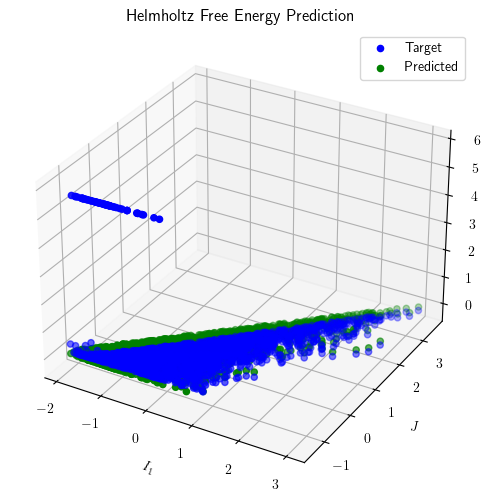

Epoch 61 | Step 20/63 | Avg Loss: 0.993357
Epoch 61 | Step 40/63 | Avg Loss: 0.965219
Epoch 61 | Step 60/63 | Avg Loss: 0.944034
Epoch 61/200 | Total Loss: 0.992282
Epoch 62 | Step 20/63 | Avg Loss: 0.918094
Epoch 62 | Step 40/63 | Avg Loss: 1.123413
Epoch 62 | Step 60/63 | Avg Loss: 1.019659
Epoch 62/200 | Total Loss: 0.992965
Epoch 63 | Step 20/63 | Avg Loss: 1.162368
Epoch 63 | Step 40/63 | Avg Loss: 1.004537
Epoch 63 | Step 60/63 | Avg Loss: 1.018597
Epoch 63/200 | Total Loss: 0.993049
Epoch 64 | Step 20/63 | Avg Loss: 1.281653
Epoch 64 | Step 40/63 | Avg Loss: 1.104810
Epoch 64 | Step 60/63 | Avg Loss: 1.012369
Epoch 64/200 | Total Loss: 0.996136
Epoch 65 | Step 20/63 | Avg Loss: 0.895632
Epoch 65 | Step 40/63 | Avg Loss: 0.922241
Epoch 65 | Step 60/63 | Avg Loss: 1.011056
Epoch 65/200 | Total Loss: 0.990777
Epoch 66 | Step 20/63 | Avg Loss: 1.023487
Epoch 66 | Step 40/63 | Avg Loss: 0.948484
Epoch 66 | Step 60/63 | Avg Loss: 1.015801
Epoch 66/200 | Total Loss: 0.993789
Epoch 67 |

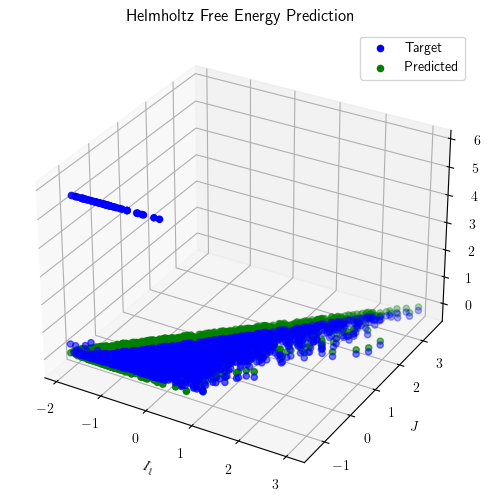

Epoch 71 | Step 20/63 | Avg Loss: 1.228317
Epoch 71 | Step 40/63 | Avg Loss: 1.002213
Epoch 71 | Step 60/63 | Avg Loss: 0.942580
Epoch 71/200 | Total Loss: 0.996379
Epoch 72 | Step 20/63 | Avg Loss: 0.711275
Epoch 72 | Step 40/63 | Avg Loss: 0.905980
Epoch 72 | Step 60/63 | Avg Loss: 1.012510
Epoch 72/200 | Total Loss: 0.993313
Epoch 73 | Step 20/63 | Avg Loss: 0.976461
Epoch 73 | Step 40/63 | Avg Loss: 0.947504
Epoch 73 | Step 60/63 | Avg Loss: 0.960952
Epoch 73/200 | Total Loss: 0.992056
Epoch 74 | Step 20/63 | Avg Loss: 0.859819
Epoch 74 | Step 40/63 | Avg Loss: 1.129386
Epoch 74 | Step 60/63 | Avg Loss: 1.001873
Epoch 74/200 | Total Loss: 0.994303
Epoch 75 | Step 20/63 | Avg Loss: 0.887614
Epoch 75 | Step 40/63 | Avg Loss: 0.887021
Epoch 75 | Step 60/63 | Avg Loss: 1.001347
Epoch 75/200 | Total Loss: 0.997922
Epoch 76 | Step 20/63 | Avg Loss: 1.064276
Epoch 76 | Step 40/63 | Avg Loss: 0.892430
Epoch 76 | Step 60/63 | Avg Loss: 1.019131
Epoch 76/200 | Total Loss: 0.993775
Epoch 77 |

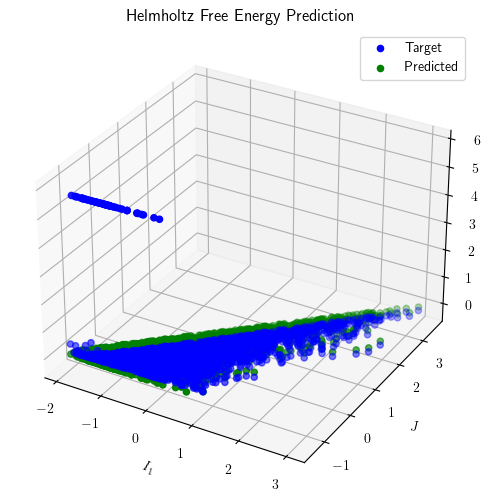

Epoch 81 | Step 20/63 | Avg Loss: 1.052484
Epoch 81 | Step 40/63 | Avg Loss: 1.008605
Epoch 81 | Step 60/63 | Avg Loss: 1.018083
Epoch 81/200 | Total Loss: 0.991935
Epoch 82 | Step 20/63 | Avg Loss: 0.763472
Epoch 82 | Step 40/63 | Avg Loss: 0.970992
Epoch 82 | Step 60/63 | Avg Loss: 1.019325
Epoch 82/200 | Total Loss: 0.990703
Epoch 83 | Step 20/63 | Avg Loss: 0.853455
Epoch 83 | Step 40/63 | Avg Loss: 0.793487
Epoch 83 | Step 60/63 | Avg Loss: 1.015532
Epoch 83/200 | Total Loss: 0.997899
Epoch 84 | Step 20/63 | Avg Loss: 1.162649
Epoch 84 | Step 40/63 | Avg Loss: 1.011425
Epoch 84 | Step 60/63 | Avg Loss: 0.981348
Epoch 84/200 | Total Loss: 0.992214
Epoch 85 | Step 20/63 | Avg Loss: 0.813315
Epoch 85 | Step 40/63 | Avg Loss: 0.944683
Epoch 85 | Step 60/63 | Avg Loss: 0.916625
Epoch 85/200 | Total Loss: 0.992349
Epoch 86 | Step 20/63 | Avg Loss: 0.698633
Epoch 86 | Step 40/63 | Avg Loss: 0.876371
Epoch 86 | Step 60/63 | Avg Loss: 0.982404
Epoch 86/200 | Total Loss: 0.991498
Epoch 87 |

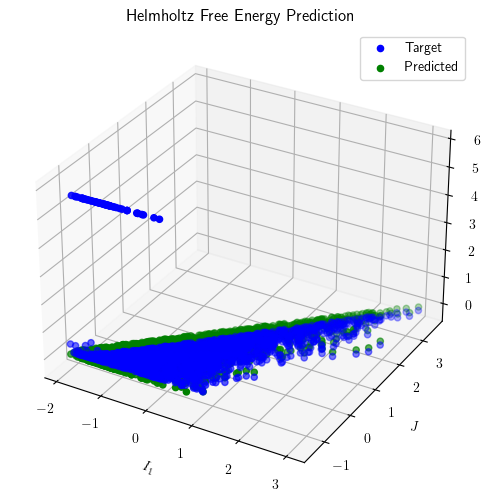

Epoch 91 | Step 20/63 | Avg Loss: 0.593320
Epoch 91 | Step 40/63 | Avg Loss: 0.821101
Epoch 91 | Step 60/63 | Avg Loss: 0.989972
Epoch 91/200 | Total Loss: 1.004555
Epoch 92 | Step 20/63 | Avg Loss: 1.183912
Epoch 92 | Step 40/63 | Avg Loss: 1.155985
Epoch 92 | Step 60/63 | Avg Loss: 0.995990
Epoch 92/200 | Total Loss: 1.015712
Epoch 93 | Step 20/63 | Avg Loss: 0.841894
Epoch 93 | Step 40/63 | Avg Loss: 0.933797
Epoch 93 | Step 60/63 | Avg Loss: 1.010210
Epoch 93/200 | Total Loss: 0.993641
Epoch 94 | Step 20/63 | Avg Loss: 1.072300
Epoch 94 | Step 40/63 | Avg Loss: 1.000692
Epoch 94 | Step 60/63 | Avg Loss: 1.002888
Epoch 94/200 | Total Loss: 0.993987
Epoch 95 | Step 20/63 | Avg Loss: 0.866077
Epoch 95 | Step 40/63 | Avg Loss: 0.886720
Epoch 95 | Step 60/63 | Avg Loss: 0.914073
Epoch 95/200 | Total Loss: 0.997594
Epoch 96 | Step 20/63 | Avg Loss: 0.666875
Epoch 96 | Step 40/63 | Avg Loss: 1.068607
Epoch 96 | Step 60/63 | Avg Loss: 0.991072
Epoch 96/200 | Total Loss: 0.997203
Epoch 97 |

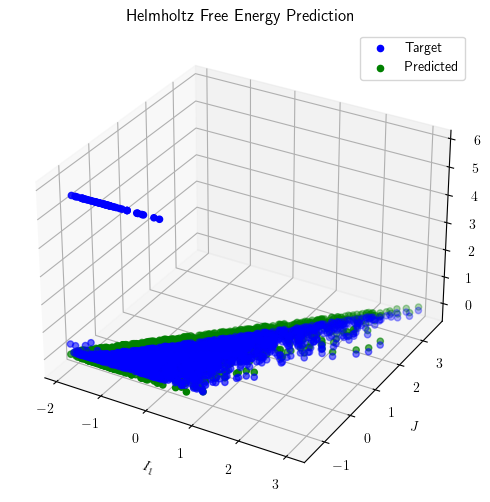

Epoch 101 | Step 20/63 | Avg Loss: 1.015364
Epoch 101 | Step 40/63 | Avg Loss: 0.900820
Epoch 101 | Step 60/63 | Avg Loss: 0.979125
Epoch 101/200 | Total Loss: 0.990345
Epoch 102 | Step 20/63 | Avg Loss: 1.030677
Epoch 102 | Step 40/63 | Avg Loss: 0.882943
Epoch 102 | Step 60/63 | Avg Loss: 0.960538
Epoch 102/200 | Total Loss: 0.998836
Epoch 103 | Step 20/63 | Avg Loss: 0.954462
Epoch 103 | Step 40/63 | Avg Loss: 0.918017
Epoch 103 | Step 60/63 | Avg Loss: 0.948109
Epoch 103/200 | Total Loss: 0.994469
Epoch 104 | Step 20/63 | Avg Loss: 1.152522
Epoch 104 | Step 40/63 | Avg Loss: 1.149074
Epoch 104 | Step 60/63 | Avg Loss: 1.010375
Epoch 104/200 | Total Loss: 0.991930
Epoch 105 | Step 20/63 | Avg Loss: 0.845733
Epoch 105 | Step 40/63 | Avg Loss: 1.136448
Epoch 105 | Step 60/63 | Avg Loss: 1.010232
Epoch 105/200 | Total Loss: 0.994344
Epoch 106 | Step 20/63 | Avg Loss: 0.977126
Epoch 106 | Step 40/63 | Avg Loss: 1.039832
Epoch 106 | Step 60/63 | Avg Loss: 1.004882
Epoch 106/200 | Total L

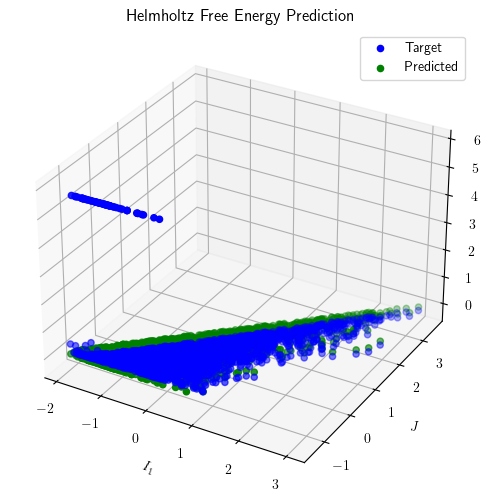

Epoch 111 | Step 20/63 | Avg Loss: 1.223685
Epoch 111 | Step 40/63 | Avg Loss: 1.065984
Epoch 111 | Step 60/63 | Avg Loss: 1.017177
Epoch 111/200 | Total Loss: 0.992002
Epoch 112 | Step 20/63 | Avg Loss: 1.193359
Epoch 112 | Step 40/63 | Avg Loss: 1.205894
Epoch 112 | Step 60/63 | Avg Loss: 1.022555
Epoch 112/200 | Total Loss: 0.996061
Epoch 113 | Step 20/63 | Avg Loss: 0.881957
Epoch 113 | Step 40/63 | Avg Loss: 1.103860
Epoch 113 | Step 60/63 | Avg Loss: 1.019152
Epoch 113/200 | Total Loss: 0.994708
Epoch 114 | Step 20/63 | Avg Loss: 1.157120
Epoch 114 | Step 40/63 | Avg Loss: 1.019422
Epoch 114 | Step 60/63 | Avg Loss: 0.990814
Epoch 114/200 | Total Loss: 0.998726
Epoch 115 | Step 20/63 | Avg Loss: 1.164014
Epoch 115 | Step 40/63 | Avg Loss: 0.922097
Epoch 115 | Step 60/63 | Avg Loss: 0.991038
Epoch 115/200 | Total Loss: 1.005873
Epoch 116 | Step 20/63 | Avg Loss: 0.905891
Epoch 116 | Step 40/63 | Avg Loss: 0.853643
Epoch 116 | Step 60/63 | Avg Loss: 0.996335
Epoch 116/200 | Total L

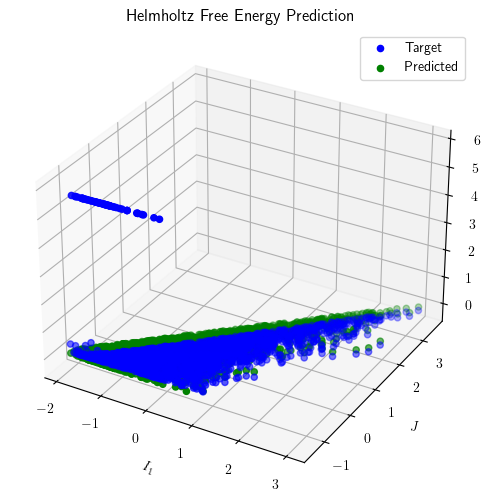

Epoch 121 | Step 20/63 | Avg Loss: 1.266918
Epoch 121 | Step 40/63 | Avg Loss: 1.058089
Epoch 121 | Step 60/63 | Avg Loss: 1.009220
Epoch 121/200 | Total Loss: 0.995339
Epoch 122 | Step 20/63 | Avg Loss: 0.991677
Epoch 122 | Step 40/63 | Avg Loss: 0.956747
Epoch 122 | Step 60/63 | Avg Loss: 0.998003
Epoch 122/200 | Total Loss: 1.002924
Epoch 123 | Step 20/63 | Avg Loss: 0.961489
Epoch 123 | Step 40/63 | Avg Loss: 1.112428
Epoch 123 | Step 60/63 | Avg Loss: 1.017606
Epoch 123/200 | Total Loss: 0.992069
Epoch 124 | Step 20/63 | Avg Loss: 0.813544
Epoch 124 | Step 40/63 | Avg Loss: 1.062081
Epoch 124 | Step 60/63 | Avg Loss: 1.011159
Epoch 124/200 | Total Loss: 0.994163
Epoch 125 | Step 20/63 | Avg Loss: 0.995899
Epoch 125 | Step 40/63 | Avg Loss: 0.863708
Epoch 125 | Step 60/63 | Avg Loss: 0.972987
Epoch 125/200 | Total Loss: 0.993822
Epoch 126 | Step 20/63 | Avg Loss: 0.918642
Epoch 126 | Step 40/63 | Avg Loss: 0.967690
Epoch 126 | Step 60/63 | Avg Loss: 0.998322
Epoch 126/200 | Total L

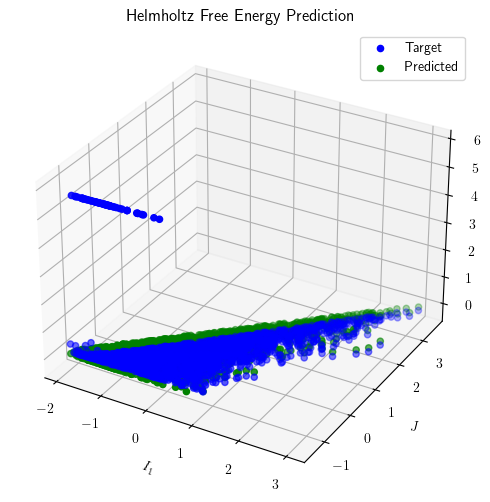

Epoch 131 | Step 20/63 | Avg Loss: 1.231135
Epoch 131 | Step 40/63 | Avg Loss: 0.947074
Epoch 131 | Step 60/63 | Avg Loss: 0.972413
Epoch 131/200 | Total Loss: 0.991563
Epoch 132 | Step 20/63 | Avg Loss: 0.759105
Epoch 132 | Step 40/63 | Avg Loss: 1.037407
Epoch 132 | Step 60/63 | Avg Loss: 0.965465
Epoch 132/200 | Total Loss: 1.018439
Epoch 133 | Step 20/63 | Avg Loss: 1.096153
Epoch 133 | Step 40/63 | Avg Loss: 1.048763
Epoch 133 | Step 60/63 | Avg Loss: 1.004694
Epoch 133/200 | Total Loss: 0.996819
Epoch 134 | Step 20/63 | Avg Loss: 0.717458
Epoch 134 | Step 40/63 | Avg Loss: 0.924328
Epoch 134 | Step 60/63 | Avg Loss: 1.003793
Epoch 134/200 | Total Loss: 0.993339
Epoch 135 | Step 20/63 | Avg Loss: 0.958585
Epoch 135 | Step 40/63 | Avg Loss: 1.045460
Epoch 135 | Step 60/63 | Avg Loss: 1.005593
Epoch 135/200 | Total Loss: 0.993500
Epoch 136 | Step 20/63 | Avg Loss: 1.286010
Epoch 136 | Step 40/63 | Avg Loss: 1.067114
Epoch 136 | Step 60/63 | Avg Loss: 1.024905
Epoch 136/200 | Total L

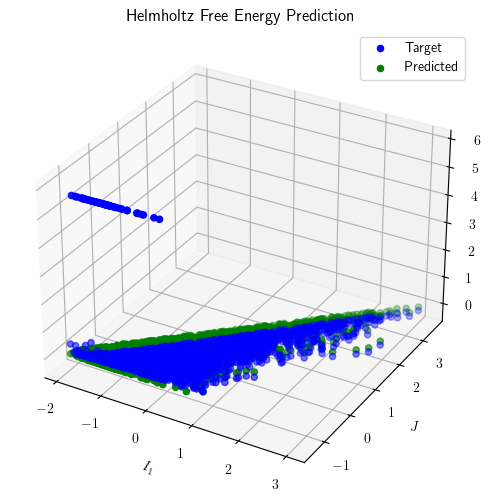

Epoch 141 | Step 20/63 | Avg Loss: 0.914271
Epoch 141 | Step 40/63 | Avg Loss: 0.914644
Epoch 141 | Step 60/63 | Avg Loss: 1.018536
Epoch 141/200 | Total Loss: 0.994090
Epoch 142 | Step 20/63 | Avg Loss: 0.965539
Epoch 142 | Step 40/63 | Avg Loss: 1.007532
Epoch 142 | Step 60/63 | Avg Loss: 1.000463
Epoch 142/200 | Total Loss: 0.994097
Epoch 143 | Step 20/63 | Avg Loss: 0.829907
Epoch 143 | Step 40/63 | Avg Loss: 1.056551
Epoch 143 | Step 60/63 | Avg Loss: 1.016509
Epoch 143/200 | Total Loss: 0.992653
Epoch 144 | Step 20/63 | Avg Loss: 0.662527
Epoch 144 | Step 40/63 | Avg Loss: 0.837878
Epoch 144 | Step 60/63 | Avg Loss: 0.938933
Epoch 144/200 | Total Loss: 1.059468
Epoch 145 | Step 20/63 | Avg Loss: 0.877509
Epoch 145 | Step 40/63 | Avg Loss: 0.891332
Epoch 145 | Step 60/63 | Avg Loss: 0.986000
Epoch 145/200 | Total Loss: 0.993266
Epoch 146 | Step 20/63 | Avg Loss: 1.291363
Epoch 146 | Step 40/63 | Avg Loss: 0.936213
Epoch 146 | Step 60/63 | Avg Loss: 1.008816
Epoch 146/200 | Total L

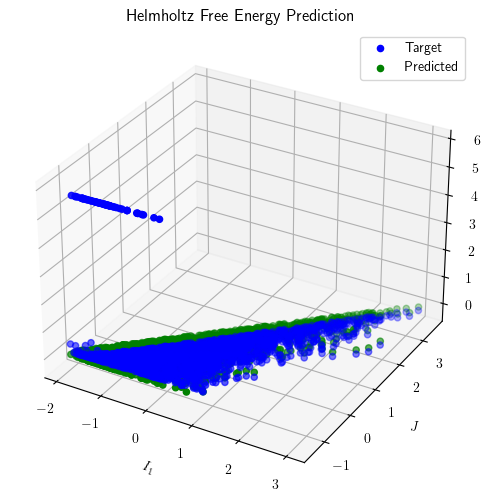

Epoch 151 | Step 20/63 | Avg Loss: 0.799755
Epoch 151 | Step 40/63 | Avg Loss: 0.886817
Epoch 151 | Step 60/63 | Avg Loss: 1.003302
Epoch 151/200 | Total Loss: 0.992737
Epoch 152 | Step 20/63 | Avg Loss: 1.281225
Epoch 152 | Step 40/63 | Avg Loss: 1.231618
Epoch 152 | Step 60/63 | Avg Loss: 1.022520
Epoch 152/200 | Total Loss: 0.992354
Epoch 153 | Step 20/63 | Avg Loss: 1.013384
Epoch 153 | Step 40/63 | Avg Loss: 1.174338
Epoch 153 | Step 60/63 | Avg Loss: 1.006737
Epoch 153/200 | Total Loss: 0.994083
Epoch 154 | Step 20/63 | Avg Loss: 0.772316
Epoch 154 | Step 40/63 | Avg Loss: 1.071182
Epoch 154 | Step 60/63 | Avg Loss: 1.014879
Epoch 154/200 | Total Loss: 0.993337
Epoch 155 | Step 20/63 | Avg Loss: 1.058176
Epoch 155 | Step 40/63 | Avg Loss: 1.099234
Epoch 155 | Step 60/63 | Avg Loss: 0.973018
Epoch 155/200 | Total Loss: 1.040860
Epoch 156 | Step 20/63 | Avg Loss: 0.887535
Epoch 156 | Step 40/63 | Avg Loss: 0.903715
Epoch 156 | Step 60/63 | Avg Loss: 0.935117
Epoch 156/200 | Total L

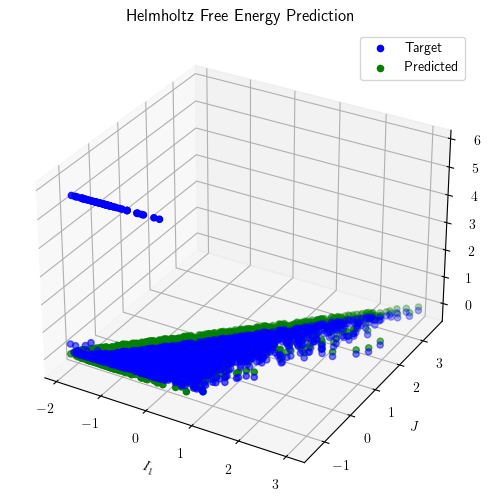

Epoch 161 | Step 20/63 | Avg Loss: 0.745361
Epoch 161 | Step 40/63 | Avg Loss: 0.992655
Epoch 161 | Step 60/63 | Avg Loss: 0.979617
Epoch 161/200 | Total Loss: 0.991829
Epoch 162 | Step 20/63 | Avg Loss: 0.813382
Epoch 162 | Step 40/63 | Avg Loss: 0.971250
Epoch 162 | Step 60/63 | Avg Loss: 0.948645
Epoch 162/200 | Total Loss: 0.991372
Epoch 163 | Step 20/63 | Avg Loss: 0.953048
Epoch 163 | Step 40/63 | Avg Loss: 1.062225
Epoch 163 | Step 60/63 | Avg Loss: 0.966937
Epoch 163/200 | Total Loss: 1.041322
Epoch 164 | Step 20/63 | Avg Loss: 0.958809
Epoch 164 | Step 40/63 | Avg Loss: 0.853615
Epoch 164 | Step 60/63 | Avg Loss: 1.023659
Epoch 164/200 | Total Loss: 0.993189
Epoch 165 | Step 20/63 | Avg Loss: 1.166137
Epoch 165 | Step 40/63 | Avg Loss: 0.959541
Epoch 165 | Step 60/63 | Avg Loss: 1.007082
Epoch 165/200 | Total Loss: 1.003649
Epoch 166 | Step 20/63 | Avg Loss: 0.629757
Epoch 166 | Step 40/63 | Avg Loss: 0.712235
Epoch 166 | Step 60/63 | Avg Loss: 0.880312
Epoch 166/200 | Total L

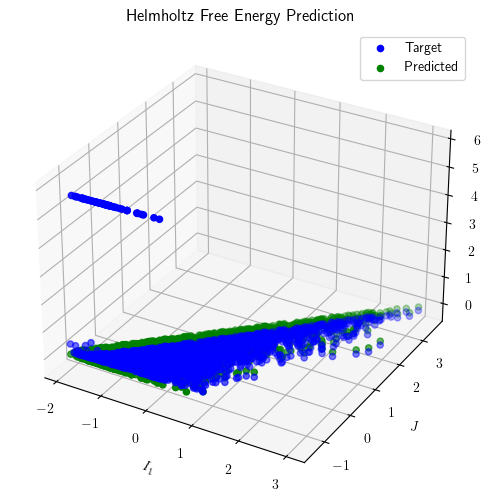

Epoch 171 | Step 20/63 | Avg Loss: 0.796160
Epoch 171 | Step 40/63 | Avg Loss: 0.786942
Epoch 171 | Step 60/63 | Avg Loss: 0.975391
Epoch 171/200 | Total Loss: 1.029170
Epoch 172 | Step 20/63 | Avg Loss: 1.019310
Epoch 172 | Step 40/63 | Avg Loss: 1.126828
Epoch 172 | Step 60/63 | Avg Loss: 1.019942
Epoch 172/200 | Total Loss: 0.991586
Epoch 173 | Step 20/63 | Avg Loss: 0.978762
Epoch 173 | Step 40/63 | Avg Loss: 0.889830
Epoch 173 | Step 60/63 | Avg Loss: 1.017287
Epoch 173/200 | Total Loss: 0.991985
Epoch 174 | Step 20/63 | Avg Loss: 0.993220
Epoch 174 | Step 40/63 | Avg Loss: 0.921290
Epoch 174 | Step 60/63 | Avg Loss: 1.013396
Epoch 174/200 | Total Loss: 0.993668
Epoch 175 | Step 20/63 | Avg Loss: 0.860633
Epoch 175 | Step 40/63 | Avg Loss: 0.837924
Epoch 175 | Step 60/63 | Avg Loss: 0.978420
Epoch 175/200 | Total Loss: 0.992472
Epoch 176 | Step 20/63 | Avg Loss: 1.200588
Epoch 176 | Step 40/63 | Avg Loss: 1.095612
Epoch 176 | Step 60/63 | Avg Loss: 1.014972
Epoch 176/200 | Total L

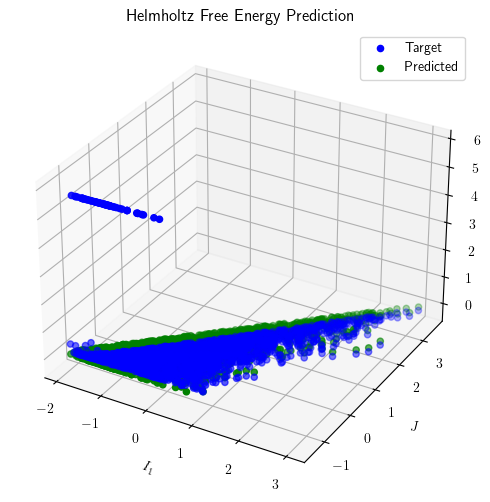

Epoch 181 | Step 20/63 | Avg Loss: 1.037786
Epoch 181 | Step 40/63 | Avg Loss: 0.960346
Epoch 181 | Step 60/63 | Avg Loss: 1.003703
Epoch 181/200 | Total Loss: 0.993898
Epoch 182 | Step 20/63 | Avg Loss: 0.753383
Epoch 182 | Step 40/63 | Avg Loss: 0.986983
Epoch 182 | Step 60/63 | Avg Loss: 1.010990
Epoch 182/200 | Total Loss: 0.994592
Epoch 183 | Step 20/63 | Avg Loss: 0.824444
Epoch 183 | Step 40/63 | Avg Loss: 0.876168
Epoch 183 | Step 60/63 | Avg Loss: 1.006464
Epoch 183/200 | Total Loss: 0.993784
Epoch 184 | Step 20/63 | Avg Loss: 1.042511
Epoch 184 | Step 40/63 | Avg Loss: 1.005336
Epoch 184 | Step 60/63 | Avg Loss: 0.984383
Epoch 184/200 | Total Loss: 0.991541
Epoch 185 | Step 20/63 | Avg Loss: 0.676066
Epoch 185 | Step 40/63 | Avg Loss: 0.914950
Epoch 185 | Step 60/63 | Avg Loss: 1.017774
Epoch 185/200 | Total Loss: 0.994982
Epoch 186 | Step 20/63 | Avg Loss: 1.445594
Epoch 186 | Step 40/63 | Avg Loss: 1.170905
Epoch 186 | Step 60/63 | Avg Loss: 1.020141
Epoch 186/200 | Total L

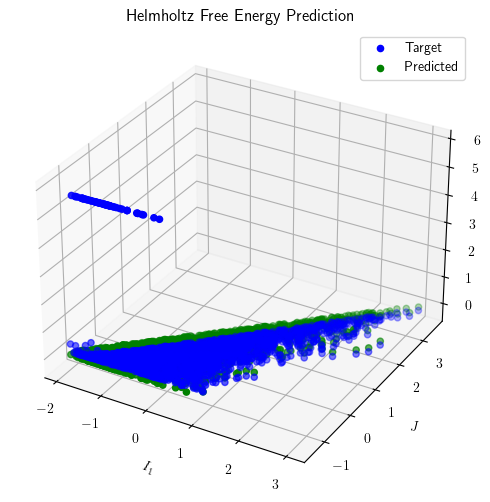

Epoch 191 | Step 20/63 | Avg Loss: 0.854793
Epoch 191 | Step 40/63 | Avg Loss: 0.904893
Epoch 191 | Step 60/63 | Avg Loss: 0.963826
Epoch 191/200 | Total Loss: 0.992824
Epoch 192 | Step 20/63 | Avg Loss: 1.418625
Epoch 192 | Step 40/63 | Avg Loss: 1.105587
Epoch 192 | Step 60/63 | Avg Loss: 1.004905
Epoch 192/200 | Total Loss: 0.992965
Epoch 193 | Step 20/63 | Avg Loss: 1.161426
Epoch 193 | Step 40/63 | Avg Loss: 1.152096
Epoch 193 | Step 60/63 | Avg Loss: 1.002253
Epoch 193/200 | Total Loss: 0.998300
Epoch 194 | Step 20/63 | Avg Loss: 1.044578
Epoch 194 | Step 40/63 | Avg Loss: 1.011842
Epoch 194 | Step 60/63 | Avg Loss: 1.023534
Epoch 194/200 | Total Loss: 0.994652
Epoch 195 | Step 20/63 | Avg Loss: 0.989766
Epoch 195 | Step 40/63 | Avg Loss: 1.121845
Epoch 195 | Step 60/63 | Avg Loss: 1.010677
Epoch 195/200 | Total Loss: 0.991672
Epoch 196 | Step 20/63 | Avg Loss: 1.285930
Epoch 196 | Step 40/63 | Avg Loss: 1.018121
Epoch 196 | Step 60/63 | Avg Loss: 1.011455
Epoch 196/200 | Total L

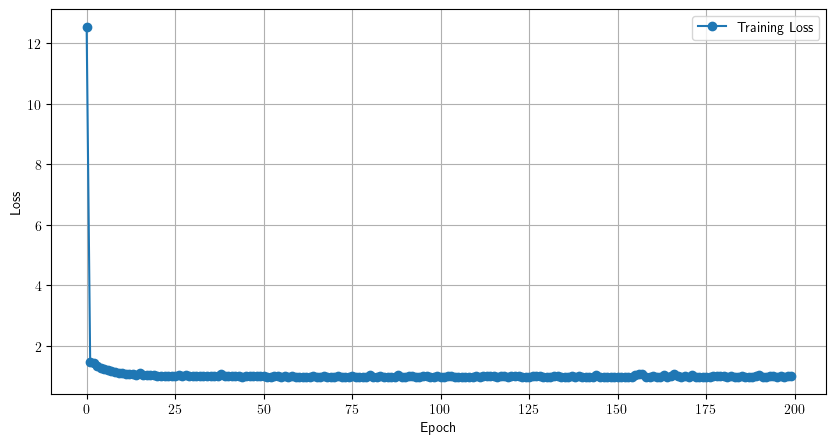

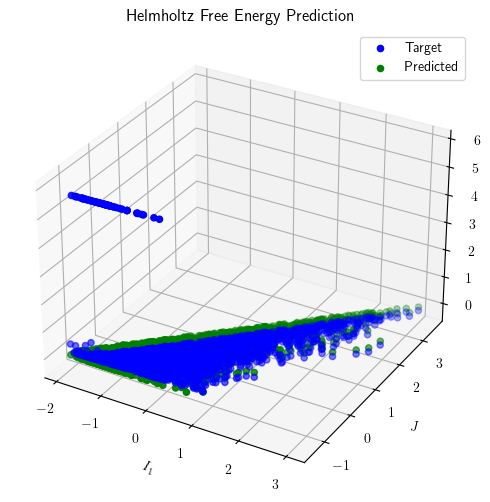

CANN()


In [44]:
model = train(train_loader, lr, epochs) # Train the model
model.load_state_dict(torch.load(model_file))  # Load trained model
eval_and_plot(model)
print(model)